# Transformations Example

- This is the accompanying code to the [medium publication](https://medium.com/towards-data-science/time-series-transformations-and-reverting-made-easy-f4f768c18f63).
- See the documentation for [SeriesTransformer](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html), [Transformer](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html#src.scalecast.Pipeline.Transformer), and [Reverter](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html#src.scalecast.Pipeline.Reverter).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster
from scalecast.SeriesTransformer import SeriesTransformer

In [2]:
data = pd.read_csv('../lstm/AirPassengers.csv')

In [3]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
f = Forecaster(
    current_dates = data['Month'],
    y = data['#Passengers'],
    future_dates = 24,
)

## Create Thumbnail Image

In [5]:
f_detrended = SeriesTransformer(f).DetrendTransform(poly_order=2)
f_diff = SeriesTransformer(f).DiffTransform()
f_diff_seas = SeriesTransformer(f).DiffTransform(12)

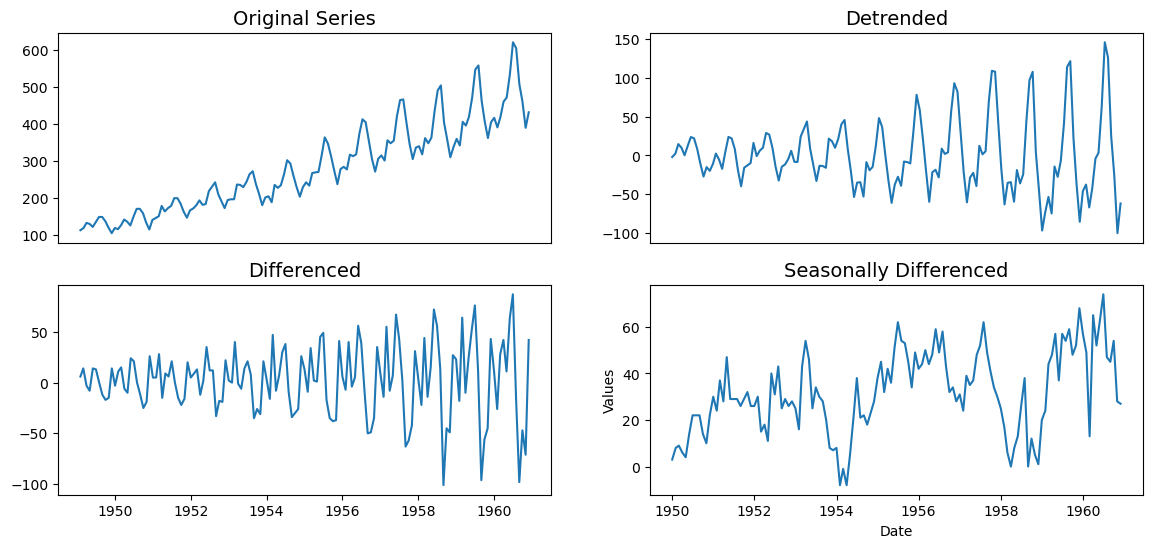

In [6]:
fig, axs = plt.subplots(2,2,figsize=(14,6))
f.plot(ax=axs[0,0])
axs[0,0].set_title('Original Series',size=14)
axs[0,0].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
axs[0,0].get_legend().remove()
f_detrended.plot(ax=axs[0,1])
axs[0,1].set_title('Detrended',size=14)
axs[0,1].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
axs[0,1].get_legend().remove()
f_diff.plot(ax=axs[1,0])
axs[1,0].set_title('Differenced',size=14)
axs[1,0].get_legend().remove()
f_diff_seas.plot(ax=axs[1,1])
axs[1,1].set_title('Seasonally Differenced',size=14)
axs[1,1].get_legend().remove()
plt.show()

## Create Transformer

In [7]:
transformer = SeriesTransformer(f)

## Apply Transformations

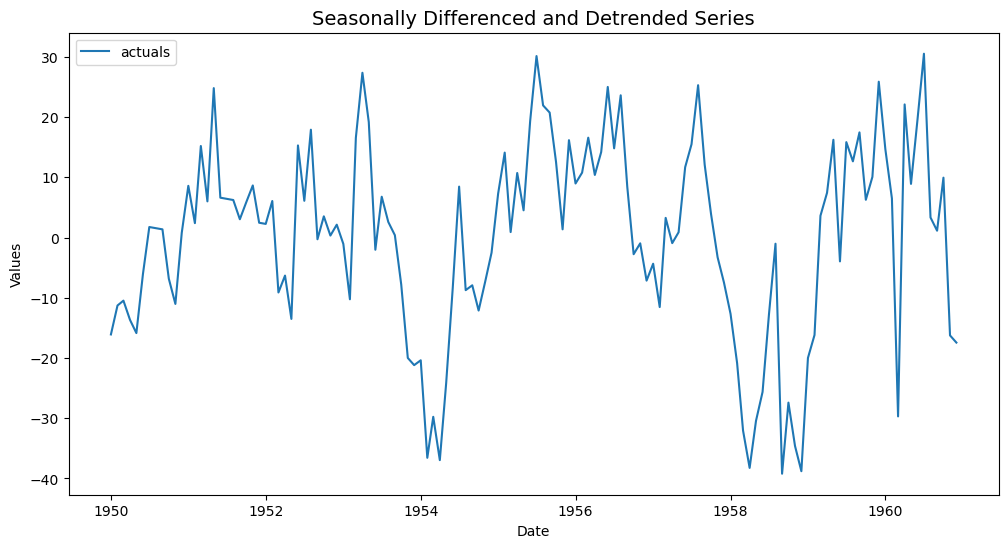

In [8]:
f = transformer.DiffTransform(12) # 12 periods is one seasonal difference for monthly data
f = transformer.DetrendTransform()
f.plot()
plt.title('Seasonally Differenced and Detrended Series',size=14);

## Forecast on Transformed Data

In [9]:
f.set_estimator('xgboost')
f.add_ar_terms(12)
f.manual_forecast(n_estimators=100,gamma=2)

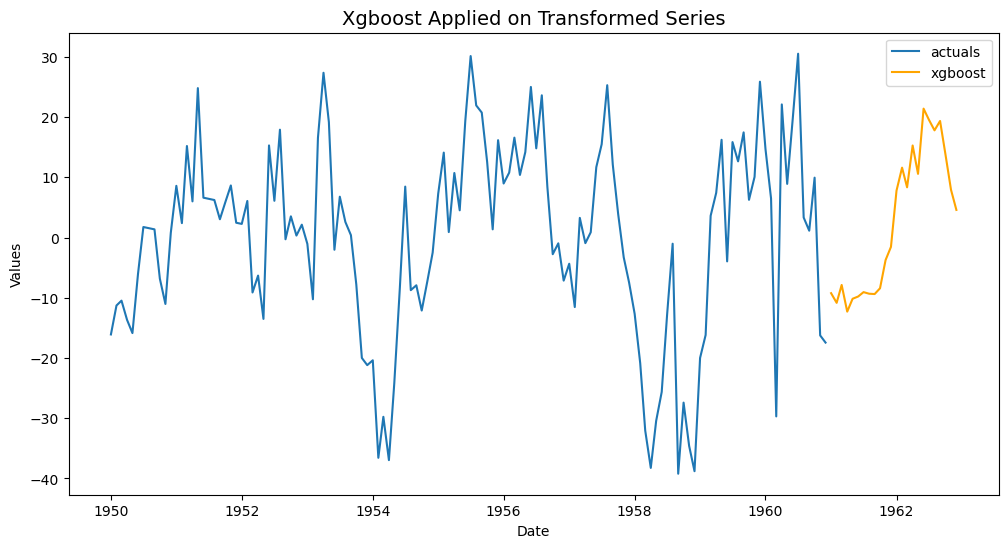

In [10]:
f.plot()
plt.title('Xgboost Applied on Transformed Series',size=14);

## Revert Transformation

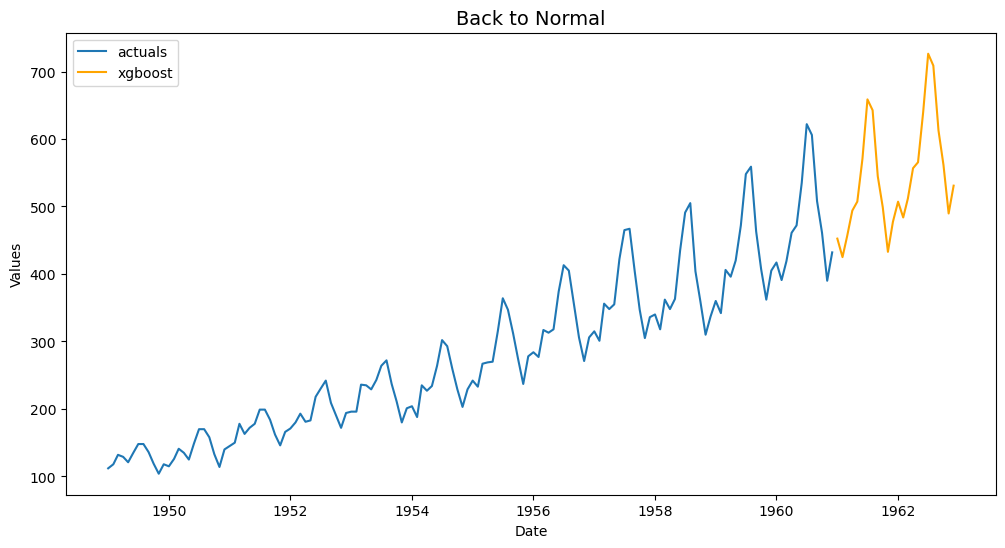

In [11]:
f = transformer.DetrendRevert()
f = transformer.DiffRevert(12)
f.plot()
plt.title('Back to Normal',size=14);

## Function to Automatically Find Optimal Transformation

In [12]:
from scalecast.util import find_optimal_transformation
# default args below
transformer, reverter = find_optimal_transformation(
    f, # Forecaster object to try the transformations on
    estimator=None, # model used to evaluate each transformation, default mlr
    monitor='rmse', # out-of-sample metric to monitor
    test_length = None, # default is the fcst horizon in the Forecaster object
    train_length = None, # default is the max available
    num_test_sets = 1, # number of test sets to iterate through, final transformation based on best avg. metric
    space_between_sets = 1, # space between consectutive train sets
    lags='auto', # uses the length of the inferred seasonality
    try_order = ['detrend','boxcox','first_diff','first_seasonal_diff','scale'], # order of transformations to try
    boxcox_lambdas = [-0.5,0,0.5], # box-cox lambas
    detrend_kwargs = [{'loess': True},{'poly_order':1},{'poly_order':2}], # detrender transform kwargs (tries as many detrenders as the length of this list)
    scale_type = ['Scale','MinMax'], # scale transformers to try
    m = 'auto', # the seasonal length to try for the seasonal adjusters, accepts multiple
    model = 'add', # the model to use when seasonally adjusting
    # specific model kwargs also accepted
)
# see what it chose
reverter

Reverter(
  reverters = [
    ('MinMaxRevert',),
    ('DetrendRevert',)
  ],
  base_transformer = Transformer(
  transformers = [
    ('DetrendTransform', {'poly_order': 2}),
    ('MinMaxTransform',)
  ]
)
)

## Automated Forecasting with Pipeline

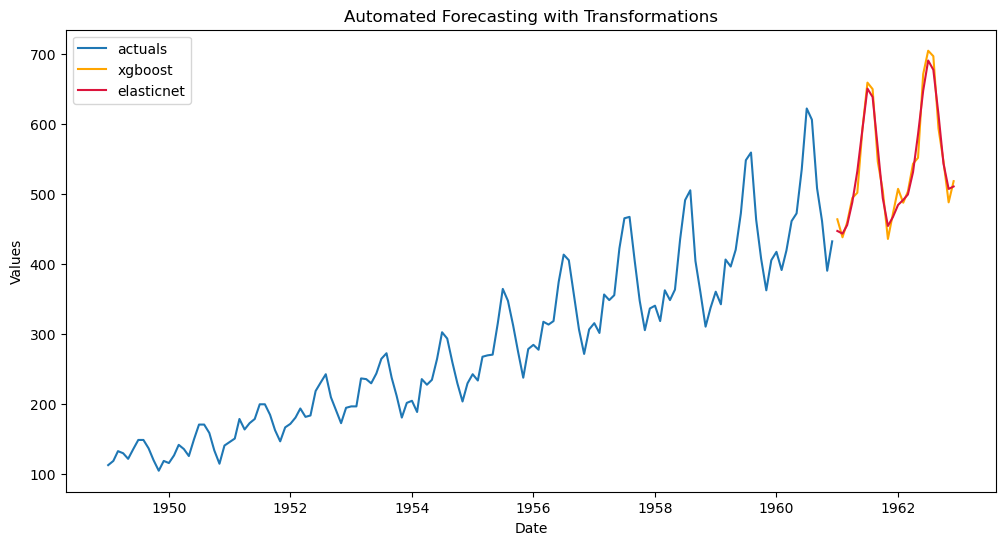

In [15]:
from scalecast.Pipeline import Pipeline
from scalecast import GridGenerator

GridGenerator.get_example_grids()

transformer, reverter = find_optimal_transformation(f)
def forecaster(f):
    f.set_test_length(20)
    f.auto_Xvar_select()
    f.tune_test_forecast(
        ['elasticnet','xgboost'],
        cross_validate=True,
        limit_grid_size = .2,
    )
    
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ],
)

f = pipeline.fit_predict(f)
f.plot()
plt.title('Automated Forecasting with Transformations');